# Import Essential Libraries

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display # to view pandas dataframe in inline mode.
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

__Disclaimer:__

_This dataset contains features of around 18k football players. We are expected to complete the following 5 major tasks. We are allowed to use only numerical attributes to cluster the data._

Language - Python (Also can use python libraries except for the $2^{nd}$ task)

In [2]:
# Import data
data_case1_normalized = pd.read_csv('Data_Case1_normalized.csv', sep = ",")
data_case2_normalized = pd.read_csv('Data_Case2_normalized.csv', sep = ",")

# Task 2: K-means

1. Implement $k$-means clustering algorithm from scratch.
2. Choose $k = 3, 5, 7$. Use only numerical attributes to cluster.
3. Use _Elbow_ method and _Silhouette Score_ to get optimal number of clusters.
4. Analyse the results got in every case and try to mark each cluster.

## Task 2.1

In [3]:
# Helper function
def dist(old_centroids, new_centroids):
    """
    Inputs:
        old_centroids - co-ordinates of OLD centroids.
        new_centroids - co-ordinates of NEW centroids (in same order).
    Output:
        sum of distances between old and new centroids.
    """
    return np.sum([np.linalg.norm(np.array(old) - np.array(new)) for old, new in zip(old_centroids, new_centroids)])

# Define k-means algorithm
def k_means(data, centroids, tol = 1e-5):
    """
    Inputs:
        data: A numpy numeric array
        centroids: initial cluster representatives = centroids
        tol: Threshold for closeness
    Output:
        Dictionary containing data points in separate clusters and centroids of those clusters
    """
    # Define an empty dictionary
    cluster_data = {"Cluster-"+str(c+1):[] for c in range(len(centroids))}
    old_centroids, new_centroids = [centroid_i+1e+6 for centroid_i in centroids], centroids # putting initial_centroids far from old for loop flow.
    while dist(old_centroids, new_centroids)>tol:
        # define Labels list
        labels_lst = []
        # Empty the dictionary list
        for key in cluster_data.keys():
            cluster_data[key] = []
        # Find new clusters by estimating distance of data_sample from centroids.
        for data_sample in data:
            idx_closest_centroid = np.argmin([np.linalg.norm(data_sample - centroid_pt) for centroid_pt in new_centroids])
            cluster_data["Cluster-"+str(idx_closest_centroid + 1)].append(data_sample)#.tolist()
            labels_lst.append(idx_closest_centroid)
        # Store old values of centroids
        old_centroids = new_centroids
        # Find new centroids
        new_centroids = np.array([np.array(cluster_data[key]).mean(axis = 0) for key in cluster_data.keys()])
    return new_centroids, np.array(labels_lst), cluster_data

# define inertia score for K-means
def kmeans_inertia(cluster_data, final_centroids):
    """
    Inputs:
        cluster_data: K-means clustered data
        centroids: centroids of clusters
    Output:
        score for such clustering
    """
    return np.sum([np.sum((np.array(cluster_data[key]) - final_centroids[int(key[-1])-1])**2) for key in cluster_data.keys()])

# Assign labels to clusters
def labels_assigner(cluster_data):
    """
    Assign labels to clustered data.
    """
    new_data = None
    for key in cluster_data.keys():
        label = np.int32(key.split('-')[1]) - 1
        if new_data is None:
            new_data = np.hstack((cluster_data[key], np.repeat(label, len(cluster_data[key])).reshape(-1,1)))
        else:
            new_data = np.vstack((new_data, np.hstack((cluster_data[key], np.repeat(label, len(cluster_data[key])).reshape(-1,1)))))
    return new_data

# recursively generate centroids
def recursive_centroids_generator(updated_data, centroid_list, req_centroids_no):
    """
    Generate Centroids with Kmeans++ algorithm...
    """
    if len(centroid_list) == req_centroids_no:
        return centroid_list
    else:
        dist_to_closest_centroid = np.array([])
        for sample in updated_data:
            dist_to_closest_centroid = np.hstack((dist_to_closest_centroid, np.min([np.linalg.norm(sample - centroid) for centroid in centroid_list])))
        farthest_sample_idx = np.random.choice(np.arange(0, len(updated_data)), 1, p = dist_to_closest_centroid/dist_to_closest_centroid.sum())
        centroid_list.append(updated_data[farthest_sample_idx])
        updated_data = np.delete(updated_data, farthest_sample_idx, axis = 0)
        return recursive_centroids_generator(updated_data, centroid_list, req_centroids_no)
    

# initialization method for centroids
def kmeans_init_centroids(data, k):#, seed = 0
    """
    Inputs:
        data: Given data from which we'll construct k no. of centroids with kmeans++ method
        k: No. of centroids = No. of clusters to be formed
    Output:
        Initial centroids from Kmeans++ method
    """
    if type(data) != np.ndarray:
        if type(data) == pd.DataFrame:
            data = data.values
        else:
            raise ValueError("Oops! the data format should be Numpy ndarray or Pandas data frame.")
    #np.random.seed(seed)
    first_centroid_index = np.random.randint(0, len(data)-1)
    centroid_list = [data[first_centroid_index]]
    updated_data = np.delete(data, first_centroid_index, axis = 0)
    return recursive_centroids_generator(updated_data, centroid_list, k)

# Final K-means function
def kmeansFunc(data, k, n_init):
    """
    1. Initialize centroids with `kmeans_init_centroids()`.
    2. Find clusters with `k_means()`.
    3. Assign labels to the cluster with `labels_assigner()` function.
    Inputs:
        data: The numeric data to be clustered.
        k: No. of clusters.
        n_init: No. of initialization to be done.
    """
    old_inertia = 1e+6
    for i in range(n_init):
        # List of centroids
        centroid_list = kmeans_init_centroids(data, k)
        # Perform K-means on the data
        final_centroids, labels, clustered_data = k_means(data, centroid_list)
        # Compute the inertia for the corresponding clustered data
        new_inertia =  kmeans_inertia(clustered_data, final_centroids)
        # Check for lowest inertia
        if i == 0:
            kmeans_centroids, kmeans_labels, kmeans_clusters = final_centroids, labels, clustered_data
        else:
            if new_inertia < old_inertia:
                kmeans_centroids, kmeans_labels, kmeans_clusters = final_centroids, labels, clustered_data
        # Store the old inertia 
        old_inertia = new_inertia
    return kmeans_centroids, kmeans_labels, kmeans_clusters

# Plot the Kmeans inertia score through elbow method and Silhouette method.
def plot_the_inertia_silhouette(data, list_of_cluster_no, n_init = 10, method = "inertia"):
    """
    data: Given Data
    list_of_cluster_no: List of Clusters
    method: "inertia" or "silhouette"
    """
    if method == "inertia":
        inertia_score = []
        for cluster in list_of_cluster_no:
            centroids, _, clusters = kmeansFunc(data, cluster, n_init = n_init)
            inertia_score.append(kmeans_inertia(clusters, centroids))
        plt.figure(figsize = (15, 10))
        plt.plot(list_of_cluster_no, inertia_score, color = "g", label = "Inertia Score")
        plt.xlabel("k"); plt.ylabel("Inertia Score"); plt.title("Inertia v/s k");plt.legend(loc = "best")
        plt.grid();plt.show()
    elif method == "silhouette":
        sil_score = []
        for cluster in list_of_cluster_no:
            _, _, clusters = kmeansFunc(data, cluster, n_init = n_init)
            composite_cluster_data = labels_assigner(clusters)
            sil_score.append(silhouette_score(composite_cluster_data[:, :-1], composite_cluster_data[:,-1]))
        plt.figure(figsize = (15, 10))
        plt.plot(list_of_cluster_no, sil_score, color = "g", label = "Silhouette Score")
        plt.xlabel("k"); plt.ylabel("Silhouette Score"); plt.title("Silhouette v/s k");plt.legend(loc = "best")
        plt.grid();plt.show()
    else:
        raise ValueError("OOps! The entered method is not correct.")

## Task 2.2

In [4]:
# Define Data for Case1 and same for Case 2
X1 = data_case1_normalized.iloc[:, 1:-2].values # From column 3 for non-normalized and upto last third column for normalized
print(f"Shape of Case 1 data: {X1.shape}")
X2 = data_case2_normalized.iloc[:, 1:-2].values
print(f"Shape of Case 2 data: {X2.shape}")

Shape of Case 1 data: (18147, 34)
Shape of Case 2 data: (18147, 37)


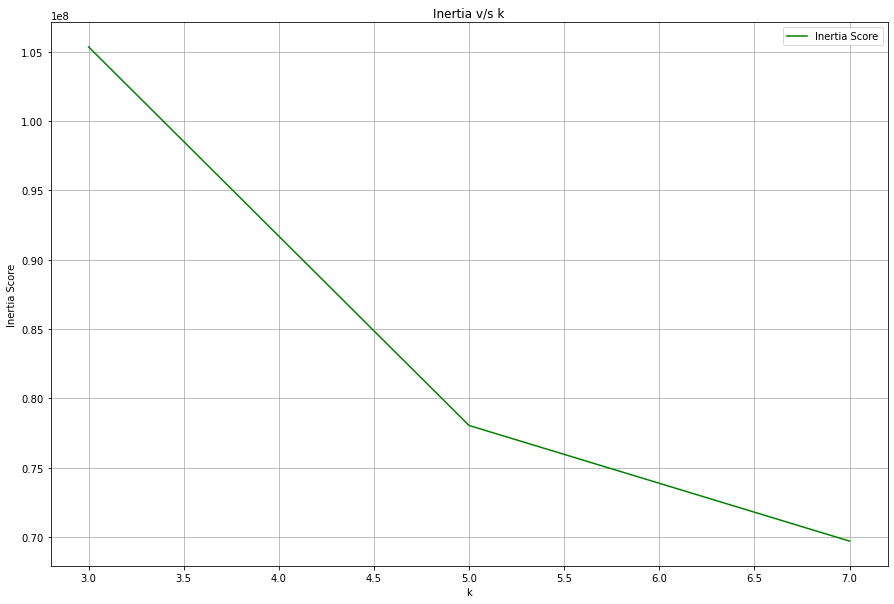

In [5]:
# For cluster 3, 5, and 7 -- FOR ELBOW method
plot_the_inertia_silhouette(X1, [3,5,7], n_init = 5, method = "inertia")

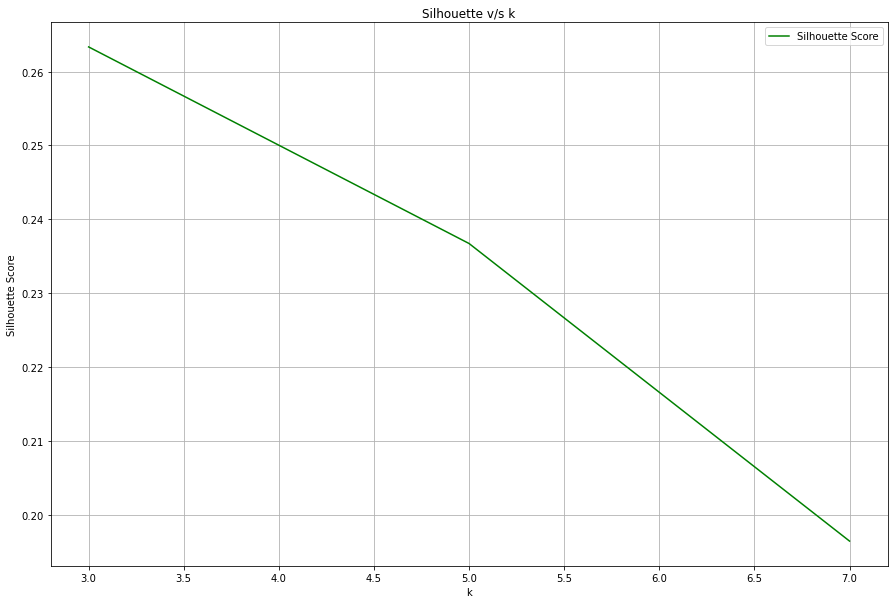

In [6]:
# For cluster 3, 5, and 7 -- FOR SILHOUETTE method
plot_the_inertia_silhouette(X1, [3,5,7], n_init = 5, method = "silhouette")

## Task 2.3

In [7]:
# List containing possible cluster numbers to be formed.
list_of_cluster_no = [i for i in range(3, 10)]

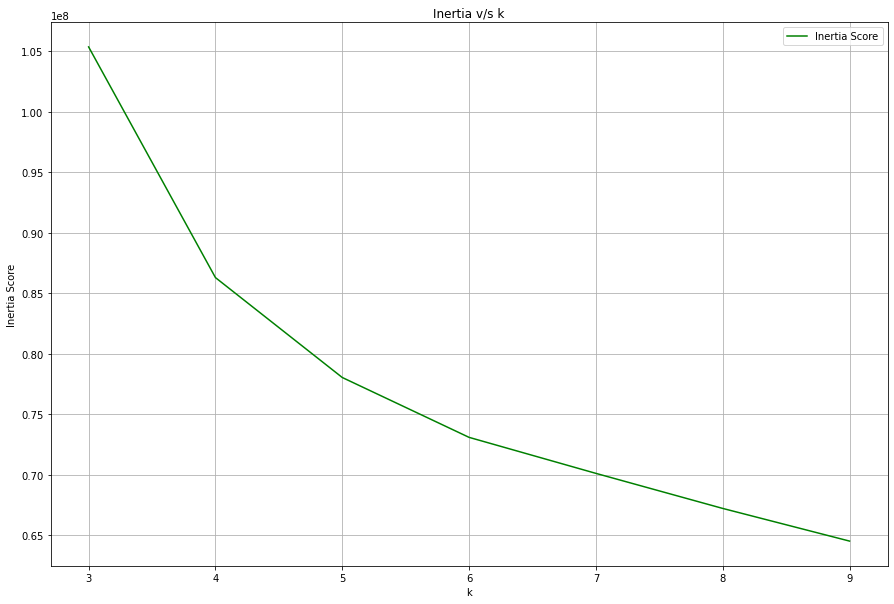

In [8]:
# For clusters 3 to 9 with Elbow Method
plot_the_inertia_silhouette(X1, list_of_cluster_no, n_init = 5, method = "inertia")

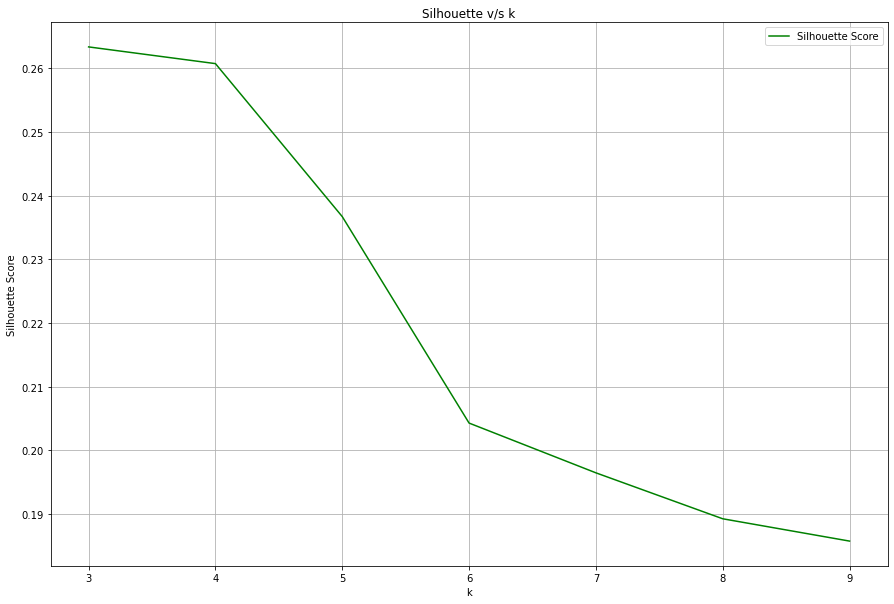

In [9]:
# For clusters 3 to 9 with Silhouette Method
plot_the_inertia_silhouette(X1, list_of_cluster_no, n_init = 5, method = "silhouette")

For Data Case 2




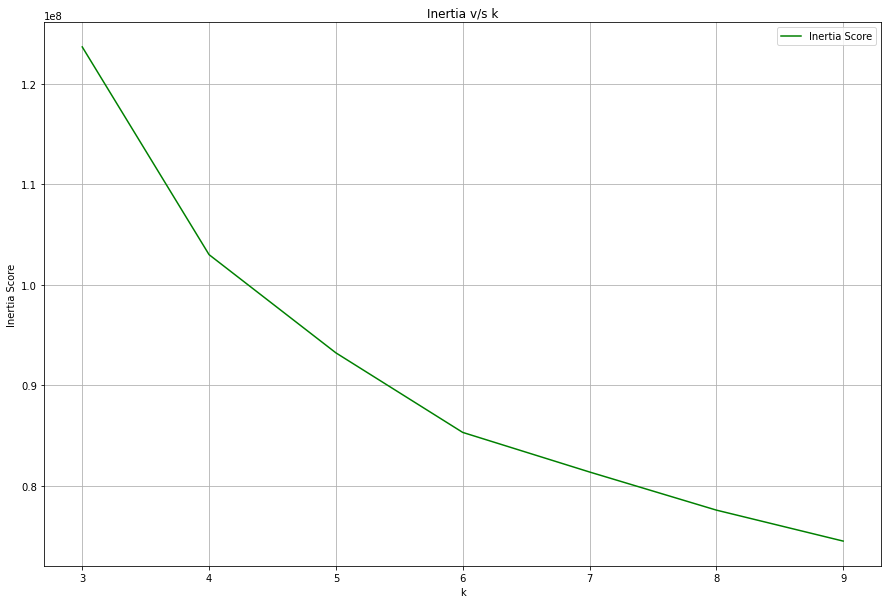

In [10]:
# For clusters 3 to 9 with Elbow Method
print("For Data Case 2\n\n")
plot_the_inertia_silhouette(X2, list_of_cluster_no, n_init = 5, method = "inertia")

For Data Case 2




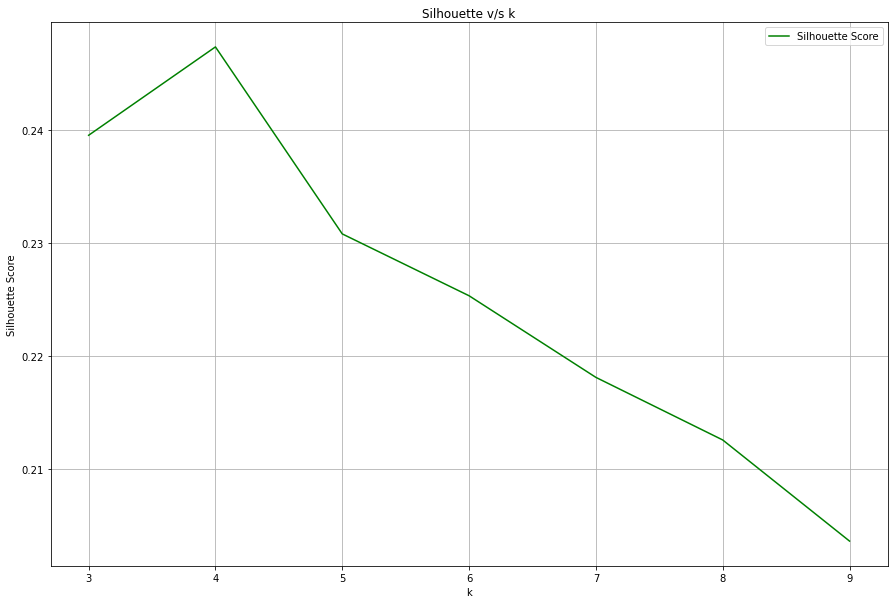

In [11]:
# For clusters 3 to 9 with Silhouette Method
print("For Data Case 2\n\n")
plot_the_inertia_silhouette(X2, list_of_cluster_no, n_init = 5, method = "silhouette")

## Task 2.4

In [17]:
# Since for k=3 we're having the best clustering
kmeans_centroids, kmeans_labels, kmeans_clusters = kmeansFunc(X2, 4, n_init = 5)

In [18]:
# Add new column to data containing its cluster information.
data_case1_normalized["Cluster"] = kmeans_labels

data_case1_normalized

,Unnamed: 0,Overall,Potential,Weak Foot,Skill Moves,Performance,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,ID,Name,Cluster
0,0,100.000,97.872,75.0,75.0,100.000,89.773,100.000,73.333,96.512,...,98.925,100.000,80.460,100.000,32.967,28.571,26.136,158023,L. Messi,3
1,1,100.000,97.872,75.0,100.0,96.774,89.773,98.925,94.444,86.047,...,100.000,85.714,91.954,98.925,27.473,31.868,22.727,20801,Cristiano Ronaldo,3
2,2,95.833,95.745,100.0,100.0,93.548,84.091,91.398,64.444,89.535,...,93.548,91.667,87.356,97.849,26.374,24.176,34.091,190871,Neymar Jr,3
3,3,93.750,95.745,50.0,0.0,93.226,13.636,11.828,18.889,50.000,...,10.753,69.048,40.230,69.892,13.187,20.879,11.364,193080,De Gea,1
4,4,93.750,93.617,100.0,75.0,90.323,100.000,86.022,56.667,98.837,...,91.398,100.000,85.057,91.398,71.429,61.538,54.545,192985,K. De Bruyne,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18142,18202,2.083,36.170,25.0,25.0,22.581,32.955,38.710,40.000,48.837,...,39.785,50.000,43.678,45.161,40.659,50.549,50.000,238813,J. Lundstram,2
18143,18203,2.083,31.915,25.0,25.0,22.581,20.455,53.763,53.333,41.860,...,47.312,27.381,43.678,41.935,20.879,14.286,18.182,243165,N. Christoffersson,1
18144,18204,2.083,40.426,50.0,25.0,22.581,22.727,40.860,46.667,36.047,...,49.462,39.286,57.471,40.860,31.868,12.088,9.091,241638,B. Worman,0
18145,18205,2.083,38.298,50.0,25.0,25.806,44.318,51.613,38.889,40.698,...,45.161,44.048,51.724,46.237,18.681,25.275,27.273,246268,D. Walker-Rice,0


In [19]:
# box-plot for each cluster to find outliers.
def box_plot_clusters(dataframe):# specific for the above transformed dataframe.
    """
    Computes distance of each data point from their cluster centroid. And compare them to find outliers.
    Return:
        Box-Plot and Outlier data in dictionary form for each cluster.
    """
    outlier_dataframe = {}
    for cluster_idx, data in dataframe.groupby("Cluster"):
        num_arr = data.iloc[:, 1:-3].values
        dist_ = np.sqrt(np.sum((num_arr - num_arr.mean(axis = 0))**2, axis = 1))
        q1, q2, q3 = np.percentile(dist_,[25,50,75])
        iqr = q3-q1
        mn, mx = q1 - 1.5*iqr, q3 + 1.5*iqr
        out_idx = np.where((dist_ > mx) | (dist_ < mn), True, False)
        outlier_dataframe[cluster_idx] = data[out_idx]
        # Display the dataframe for outliers.
        display(outlier_dataframe[cluster_idx]) # or also we can use outlier_dataframe[cluster_idx].style to view.
        # Box-Plot...
        plt.figure(figsize = (10,8))
        plt.boxplot(dist_)
        plt.title(f"Box-Plot for Cluster: {cluster_idx + 1}"); plt.show()
    return outlier_dataframe

,Unnamed: 0,Overall,Potential,Weak Foot,Skill Moves,Performance,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,ID,Name,Cluster
345,345,72.917,76.596,75.0,50.0,77.419,54.545,88.172,81.111,70.930,...,88.172,57.143,74.713,77.419,18.681,19.780,13.636,207877,J. Martínez,0
529,529,70.833,68.085,25.0,75.0,74.194,64.773,87.097,73.333,75.581,...,84.946,76.190,80.460,83.871,8.791,24.176,10.227,171833,D. Sturridge,0
589,589,68.750,80.851,75.0,75.0,69.355,69.318,73.118,54.444,75.581,...,77.419,71.429,48.276,74.194,25.275,15.385,21.591,216388,A. Saint-Maximin,0
732,732,66.667,80.851,100.0,50.0,74.194,65.909,84.946,80.000,75.581,...,81.720,65.476,63.218,75.269,17.582,26.374,14.773,232432,L. Jović,0
758,758,66.667,63.830,50.0,50.0,72.581,48.864,84.946,87.778,66.279,...,83.871,51.190,80.460,69.892,21.978,21.978,27.273,224116,Dyego Sousa,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18094,18154,4.167,38.298,25.0,25.0,24.194,55.682,45.161,18.889,44.186,...,43.011,45.238,44.828,47.312,21.978,25.275,26.136,243204,M. Roberts,0
18116,18176,4.167,19.149,25.0,25.0,25.806,39.773,48.387,37.778,45.349,...,40.860,35.714,47.126,35.484,16.484,25.275,25.000,246227,T. Hillman,0
18140,18200,2.083,29.787,25.0,25.0,22.581,26.136,48.387,47.778,40.698,...,47.312,32.143,60.920,50.538,13.187,16.484,12.500,231381,J. Young,0
18144,18204,2.083,40.426,50.0,25.0,22.581,22.727,40.860,46.667,36.047,...,49.462,39.286,57.471,40.860,31.868,12.088,9.091,241638,B. Worman,0


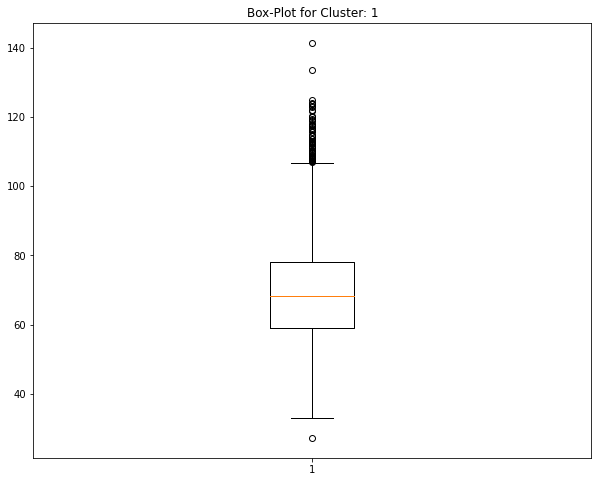

,Unnamed: 0,Overall,Potential,Weak Foot,Skill Moves,Performance,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,ID,Name,Cluster
3,3,93.750,95.745,50.0,0.0,93.226,13.636,11.828,18.889,50.000,...,10.753,69.048,40.230,69.892,13.187,20.879,11.364,193080,De Gea,1
9,9,91.667,95.745,50.0,0.0,89.677,9.091,9.677,12.222,25.581,...,9.677,71.429,6.897,72.043,26.374,10.989,17.045,200389,J. Oblak,1
18,18,89.583,93.617,75.0,0.0,90.323,11.364,12.903,7.778,33.721,...,9.677,70.238,22.989,70.968,24.176,12.088,7.955,192448,M. ter Stegen,1
19,19,89.583,89.362,25.0,0.0,86.129,10.227,12.903,10.000,30.233,...,11.828,40.476,25.287,67.742,18.681,17.582,14.773,192119,T. Courtois,1
22,22,89.583,87.234,75.0,0.0,92.258,11.364,11.828,23.333,55.814,...,10.753,71.429,48.276,72.043,15.385,8.791,9.091,167495,M. Neuer,1
37,37,87.500,85.106,0.0,0.0,83.871,9.091,8.602,6.667,50.000,...,8.602,23.810,40.230,66.667,28.571,8.791,17.045,167948,H. Lloris,1
40,40,87.500,85.106,25.0,0.0,85.484,7.955,8.602,6.667,33.721,...,10.753,36.905,20.690,70.968,24.176,8.791,11.364,162835,S. Handanovič,1
41,41,87.500,85.106,25.0,0.0,86.129,9.091,13.978,10.000,34.884,...,10.753,47.619,19.540,72.043,10.989,9.890,9.091,1179,G. Buffon,1
46,46,85.417,82.979,50.0,0.0,84.839,6.818,13.978,7.778,26.744,...,15.054,69.048,22.989,68.817,27.473,13.187,12.500,193041,K. Navas,1
57,57,83.333,89.362,50.0,0.0,87.097,17.045,12.903,11.111,56.977,...,19.355,67.857,13.793,72.043,27.473,14.286,5.682,210257,Ederson,1


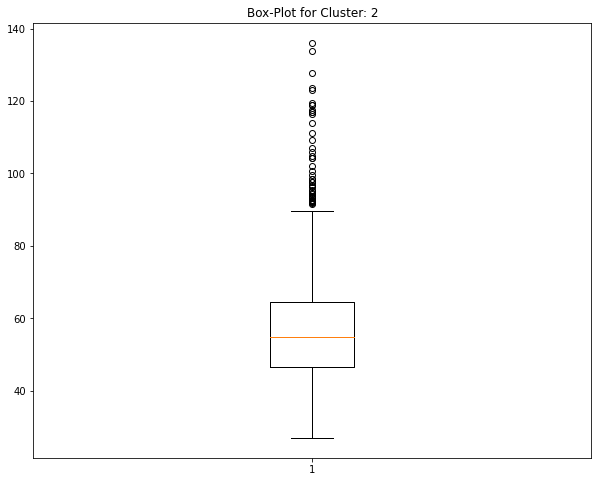

,Unnamed: 0,Overall,Potential,Weak Foot,Skill Moves,Performance,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,ID,Name,Cluster
44,44,85.417,89.362,50.0,25.0,85.484,28.409,18.280,85.556,68.605,...,23.656,39.286,32.184,80.645,96.703,94.505,94.318,201024,K. Koulibaly,2
73,73,83.333,80.851,50.0,25.0,85.484,45.455,48.387,87.778,67.442,...,38.710,44.048,41.379,84.946,94.505,93.407,93.182,177509,M. Benatia,2
77,77,81.250,93.617,75.0,25.0,83.871,39.773,43.011,84.444,73.256,...,30.108,55.952,58.621,82.796,97.802,94.505,89.773,232363,M. Škriniar,2
88,88,81.250,82.979,25.0,25.0,83.871,25.000,8.602,84.444,61.628,...,24.731,14.286,24.138,81.720,91.209,93.407,97.727,192774,K. Manolas,2
110,110,79.167,85.106,50.0,25.0,82.258,35.227,40.860,84.444,81.395,...,34.409,46.429,44.828,77.419,89.011,91.209,96.591,220793,D. Sánchez,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18108,18168,4.167,23.404,50.0,25.0,24.194,26.136,22.581,45.556,23.256,...,24.731,22.619,36.782,43.011,42.857,57.143,57.955,245417,J. Manley,2
18111,18171,4.167,0.000,50.0,25.0,25.806,52.273,31.183,36.667,61.628,...,35.484,44.048,32.184,63.441,46.154,50.549,44.318,237746,Y. Uchimura,2
18115,18175,4.167,23.404,25.0,25.0,24.194,39.773,24.731,37.778,25.581,...,44.086,33.333,39.080,29.032,46.154,54.945,52.273,243649,E. Clarke,2
18119,18179,4.167,34.043,50.0,25.0,24.194,22.727,21.505,43.333,26.744,...,27.957,20.238,31.034,36.559,42.857,53.846,52.273,246243,J. Williams,2


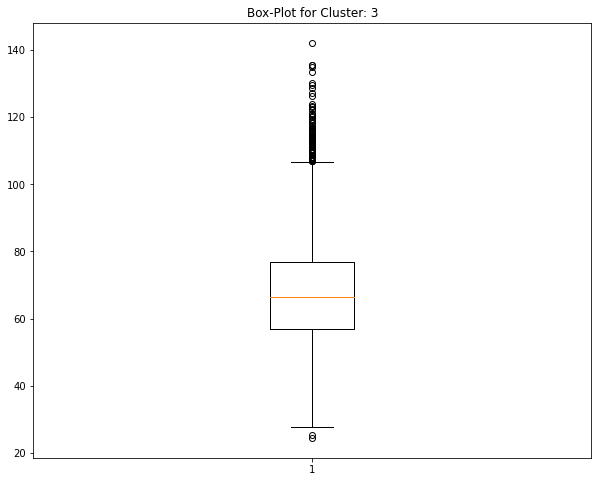

,Unnamed: 0,Overall,Potential,Weak Foot,Skill Moves,Performance,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,ID,Name,Cluster
0,0,100.000,97.872,75.0,75.0,100.000,89.773,100.000,73.333,96.512,...,98.925,100.000,80.460,100.000,32.967,28.571,26.136,158023,L. Messi,3
1,1,100.000,97.872,75.0,100.0,96.774,89.773,98.925,94.444,86.047,...,100.000,85.714,91.954,98.925,27.473,31.868,22.727,20801,Cristiano Ronaldo,3
2,2,95.833,95.745,100.0,100.0,93.548,84.091,91.398,64.444,89.535,...,93.548,91.667,87.356,97.849,26.374,24.176,34.091,190871,Neymar Jr,3
4,4,93.750,93.617,100.0,75.0,90.323,100.000,86.022,56.667,98.837,...,91.398,100.000,85.057,91.398,71.429,61.538,54.545,192985,K. De Bruyne,3
5,5,93.750,91.489,75.0,75.0,91.935,86.364,88.172,63.333,95.349,...,91.398,94.048,93.103,94.624,34.066,27.473,21.591,183277,E. Hazard,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2196,58.333,55.319,100.0,50.0,66.129,77.273,75.269,42.222,77.907,...,77.419,77.381,77.011,86.022,7.692,34.066,31.818,230466,Fábio Melitinho,3
2645,2645,56.250,53.191,100.0,25.0,64.516,76.136,62.366,75.556,80.233,...,65.591,77.381,77.011,84.946,74.725,74.725,71.591,54033,T. Huddlestone,3
3550,3550,54.167,51.064,50.0,50.0,62.903,85.227,67.742,26.667,82.558,...,70.968,76.190,89.655,79.570,40.659,39.560,35.227,29552,S. Nakamura,3
3570,3570,54.167,51.064,25.0,25.0,64.516,72.727,53.763,81.111,70.930,...,55.914,48.810,62.069,69.892,78.022,79.121,76.136,185204,Diego Ângelo,3


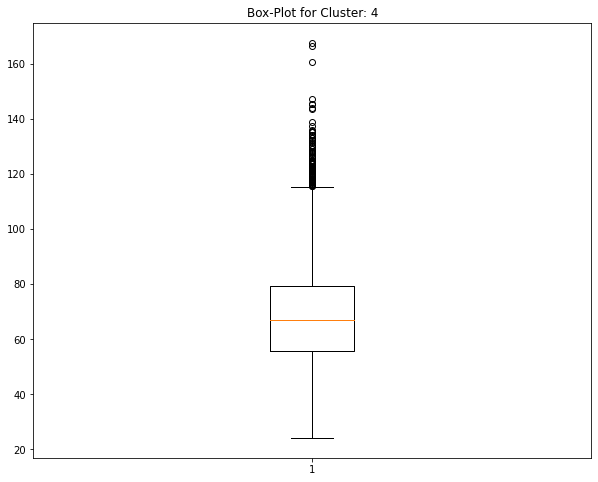

In [20]:
# Let's do it...
_ = box_plot_clusters(data_case1_normalized)